<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 3. Обучение с учителем. Методы классификации
## <center>Практика. Дерево решений в задаче предсказания выживания пассажиров "Титаника". Решение

**Заполните код в клетках и выберите ответы в [веб-форме](https://goo.gl/TBwVhQ).**

**<a href="https://www.kaggle.com/c/titanic">Соревнование</a> Kaggle "Titanic: Machine Learning from Disaster".**

In [96]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

**Функция для формирования csv-файла посылки на Kaggle:**

In [97]:
def write_to_submission_file(
    predicted_labels,
    out_file,
    train_num=891,
    target="Survived",
    index_label="PassengerId",
):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(train_num + 1, train_num + 1 + predicted_labels.shape[0]),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

**Считываем обучающую и тестовую выборки.**

In [98]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [99]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML 2/HW 1/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML 2/HW 1/test.csv")

In [100]:
y = train_df["Survived"]

In [101]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [102]:
train_df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [103]:
test_df.describe(include="all")

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


**Заполним пропуски медианными значениями.**

In [104]:
train_df["Age"].fillna(train_df["Age"].median(), inplace=True)
test_df["Age"].fillna(train_df["Age"].median(), inplace=True)
train_df["Embarked"].fillna("S", inplace=True)
test_df["Fare"].fillna(train_df["Fare"].median(), inplace=True)

<ipython-input-104-184a2cc71254>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["Age"].fillna(train_df["Age"].median(), inplace=True)
<ipython-input-104-184a2cc71254>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

**Кодируем категориальные признаки `Pclass`, `Sex`, `SibSp`, `Parch` и `Embarked` с помощью техники One-Hot-Encoding.**

In [105]:
train_df = pd.concat(
    [
        train_df,
        pd.get_dummies(train_df["Pclass"], prefix="PClass"),
        pd.get_dummies(train_df["Sex"], prefix="Sex"),
        pd.get_dummies(train_df["SibSp"], prefix="SibSp"),
        pd.get_dummies(train_df["Parch"], prefix="Parch"),
        pd.get_dummies(train_df["Embarked"], prefix="Embarked"),
    ],
    axis=1,
)
test_df = pd.concat(
    [
        test_df,
        pd.get_dummies(test_df["Pclass"], prefix="PClass"),
        pd.get_dummies(test_df["Sex"], prefix="Sex"),
        pd.get_dummies(test_df["SibSp"], prefix="SibSp"),
        pd.get_dummies(test_df["Parch"], prefix="Parch"),
        pd.get_dummies(test_df["Embarked"], prefix="Embarked"),
    ],
    axis=1,
)

In [106]:
train_df.drop(
    [
        "Survived",
        "Pclass",
        "Name",
        "Sex",
        "SibSp",
        "Parch",
        "Ticket",
        "Cabin",
        "Embarked",
        "PassengerId",
    ],
    axis=1,
    inplace=True,
)
test_df.drop(
    [
        "Pclass",
        "Name",
        "Sex",
        "SibSp",
        "Parch",
        "Ticket",
        "Cabin",
        "Embarked",
        "PassengerId",
    ],
    axis=1,
    inplace=True,
)

**В тестовой выборке появляется новое значение Parch = 9, которого нет в обучающей выборке. Проигнорируем его.**

In [107]:
train_df.shape, test_df.shape

((891, 24), (418, 25))

In [108]:
set(test_df.columns) - set(train_df.columns)

{'Parch_9'}

In [109]:
test_df.drop(["Parch_9"], axis=1, inplace=True)

In [110]:
train_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,22.0,7.2500,False,False,True,False,True,False,True,False,...,True,False,False,False,False,False,False,False,False,True
1,38.0,71.2833,True,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,True,False,False
2,26.0,7.9250,False,False,True,True,False,True,False,False,...,True,False,False,False,False,False,False,False,False,True
3,35.0,53.1000,True,False,False,True,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
4,35.0,8.0500,False,False,True,False,True,True,False,False,...,True,False,False,False,False,False,False,False,False,True


In [111]:
test_df.head()

,Age,Fare,PClass_1,PClass_2,PClass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,...,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S
0,34.5,7.8292,False,False,True,False,True,True,False,False,...,True,False,False,False,False,False,False,False,True,False
1,47.0,7.0000,False,False,True,True,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
2,62.0,9.6875,False,True,False,False,True,True,False,False,...,True,False,False,False,False,False,False,False,True,False
3,27.0,8.6625,False,False,True,False,True,True,False,False,...,True,False,False,False,False,False,False,False,False,True
4,22.0,12.2875,False,False,True,True,False,False,True,False,...,False,True,False,False,False,False,False,False,False,True


## 1. Дерево решений без настройки параметров

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 2. Используйте параметр `random_state=17` для воспроизводимости результатов.**

In [112]:
tree_train = DecisionTreeClassifier(max_depth=2, random_state=17)
tree_train.fit(train_df, y)

DecisionTreeClassifier(max_depth=2, random_state=17)

**Сделайте с помощью полученной модели прогноз для тестовой выборки **

In [113]:
predictions = tree_train.predict(test_df)

**Сформируйте файл посылки и отправьте на Kaggle**

In [114]:
write_to_submission_file(predictions, out_file='out.csv')

<font color='red'>Вопрос 1. </font> Каков результат первой посылки (дерево решений без настройки параметров) в публичном рейтинге соревнования Titanic?
- 0.746
- 0.756
- 0.766
- 0.776

**Отобразите дерево с помощью `export_graphviz` и `dot`.**

In [115]:
export_graphviz(tree_train, feature_names=train_df.columns, out_file='tree.dot', filled=True)
!dot -Tpng tree.dot -o tree.png

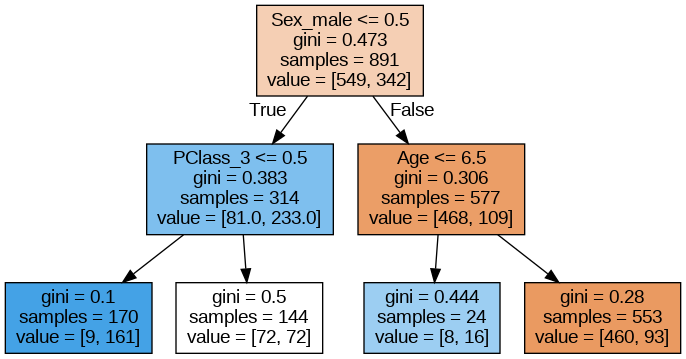

In [116]:
from IPython.display import Image
Image('tree.png')

<font color='red'>Вопрос 2. </font> Сколько признаков задействуются при прогнозе деревом решений глубины 2?
- 2
- 3
- 4
- 5

## 2. Дерево решений с настройкой параметров

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`). Также укажите `random_state=17`. Максимальную глубину и минимальное число элементов в листе настройте на 5-кратной кросс-валидации с помощью `GridSearchCV`.**

In [117]:
# tree params for grid search
tree_params = {"max_depth": list(range(1, 5)), "min_samples_leaf": list(range(1, 5))}

grid = GridSearchCV(tree_train, tree_params, cv=5)
train_grid = grid.fit(train_df, y)
train_grid.best_params_, train_grid.best_score_

({'max_depth': 3, 'min_samples_leaf': 3}, 0.8103132257862031)

<font color='red'>Вопрос 3. </font> Каковы лучшие параметры дерева, настроенные на кросс-валидации с помощью `GridSearchCV`?
- max_depth=2, min_samples_leaf=1
- max_depth=2, min_samples_leaf=4
- max_depth=3, min_samples_leaf=2
- max_depth=3, min_samples_leaf=3

<font color='red'>Вопрос 4. </font> Какой получилась средняя доля верных ответов на кросс-валидации для дерева решений с лучшим сочетанием гиперпараметров `max_depth` и `min_samples_leaf`?
- 0.77
- 0.79
- 0.81
- 0.83

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [118]:
train_tree_params = DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=17)
train_tree_params.fit(train_df, y)
test_predict = train_tree_params.predict(test_df)

**Сформируйте файл посылки и отправьте на Kaggle.**

In [119]:
write_to_submission_file(test_predict, out_file='out2.csv')

<font color='red'>Вопрос 5. </font> Каков результат второй посылки (дерево решений с настройкой гиперпараметров) в публичном рейтинге соревнования Titanic?
- 0.7499
- 0.7599
- 0.7699
- 0.7799

## Ссылки:

 - <a href="https://www.kaggle.com/c/titanic">Соревнование</a> Kaggle "Titanic: Machine Learning from Disaster"
 - <a href="https://www.dataquest.io/mission/74/getting-started-with-kaggle/">Тьюториал</a> Dataquest по задаче Kaggle "Titanic: Machine Learning from Disaster"